## Seaside Example Notebook 1: Multi-Hazard Building Damage

This notebook uses the pyIncore modeling framework to compute multi-hazard damages to buildings in Seaside, Oregon. pyIncore's **BuildingDamage** and **MonteCarloFailureProbability** modules are implemented to compute damages resulting from both an earthquake and tsunami. pyIncore's **cumulativebuildingdamage** module is used to compute cumulative damages.


*Notebook created by Dylan R. Sanderson (OSU - sanderdy@oregonstate.edu) and Gowtham Naraharisetty (NCSA) 

***
### 1. Background

Communities around the world are subject to multiple natural hazards that often occur near simultaneously. For example, hurricanes often result in high wind speeds, as well as flooding from both rainfall and storm surge. Similarly, seismic events can result in earthquakes, tsunamis, and landslides. When considering multi-hazards, there is a consensus that the total expected damages are not the sum of the underlying single hazards. For example, in the case of seismic-tsunami events, a building completely destroyed by an earthquake cannot sustain any more damage from the tsunami. Subsequently, it is essential to consider this when performing a multi-hazard damage analysis. 

In this notebook, the seismic-tsunami hazard posed by the Cascadia Subduction Zone (CSZ) is considered to demonstrate the multi-hazard capabilities in pyIncore. The CSZ is an approximately 1,000 km long fault located between Cape Mendocino California and Vancouver Island, Canada, which separates the Juan de Fuca and North America plates. Rupture of the CSZ will result in a megathrust earthquake and lead to a subsequent tsunami. The city of Seaside is located along the northern Oregon coast, and has been selected as a testbed community for this analysis.

![title](images/seaside.png)<br>

#### 1.1. Hazards, Infrastructure, and Damage Analysis
The results of a Probabilistic Seismic-Tsunami Hazard Analysis (PSTHA; Park *et. al.* 2017) are utilized in this notebook. The PSTHA resulted in both earthquake and tsunami hazard maps for 7 recurrence intervals (100-, 250-, 500-, 1,000-, 2,500-, 5,000-, and 10,000-year). The damages to buildings are computed in pyIncore by overlaying the hazard maps on the buildings, and determining site-specific intensity measures. Intensity measures of spectral displacement and momentum flux are used for the earthquake and tsunami respectively. MAEVIS fragilities are then implemented to determine the probability that each building sustains: (1) insignificant, (2) moderate, (3) heavy, or (4) complete damage. These probabilities are then used to inform a Monte-Carlo simulation in which the probability of building failure is computed.

![Hazards](images/hazards.png)

![Buildings](images/Buildings.png)

***
### 2. pyIncore
The remainder of this notebook uses pyIncore to compute multi-hazard damages to buildings in Seaside, Oregon.

#### 2.1. Prerequisites
The following modules are necessary to run this notebook. To ensure dependencies are correct, install all modules through conda-forge. 

| Module | Version | Notes |
| --- | --- | --- |
| pyIncore | =>0.5.3 | see: https://incore.ncsa.illinois.edu/doc/incore/install_pyincore.html |
| geopandas | 0.6.2 | used for working with geospatial data | 
| matplotlib | 3.1.2 | used for plotting results |
| IPython | 7.10.2 | used for displaying results in table |
| ipyleaflet | 0.10.5 | used for geospatial visualization |
| ipywidgets | 7.5.1 | used for interacting with geospatial results |
| branca | 0.3.1 | used in geospatial visualization | 
| map_creation_backend.py* | - | backend code used for geospatial visualization already included in the zip file |

\* **map_creation_backend.py** is used to geospatially visualize the results of pyIncore within the notebook. The geospatial results are interactive. The above modules need to be installed for map_creation_backend.py to run.


#### 2.2. Importing pyIncore Modules
All of the necessary pyIncore modules are being imported. In this analysis, the following pyIncore modules are utilized:
+ **BuildingDamage**: Computes probability of each building being in a damage state for both the earthquake and tsunami hazard.
+ **CumulativeBuildingDamage**: Combines the results of earthquake and tsunami building damage analysis to compute the multi-hazard damages
+ **MonteCarloFailureProbability**: Computes the failure probability of each building.

In [1]:
from pyincore import IncoreClient, Dataset, FragilityService, MappingSet
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.cumulativebuildingdamage import CumulativeBuildingDamage
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability
from pyincore_viz.geoutil import GeoUtil as viz

import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

client = IncoreClient()

Connection successful to IN-CORE services. pyIncore version detected: 0.8.0


### 3. Performing Earthquake and Tsunami Building Damage
This section of the code computes both the earthquake and tsunami building damages using pyIncore's **BuildingDamage** module. The earthquake damage for events corresponding to return periods of 100-2,500-year is first computed followed by the tsunami damage for the same recurrence intervals. pyIncore uses IDs to identify hazard datasets, infrastructure datasets, fragilities, *etc.*. The hazard IDs for these 5 recurrence intervals of both the earthquake and tsunami are:

| Recurrence Interval | Earthquake | Tsunami |
| --- | --- | --- |
| 100-yr | 5dfa4058b9219c934b64d495 | 5bc9e25ef7b08533c7e610dc |
| 250-yr | 5dfa41aab9219c934b64d4b2 | 5df910abb9219cd00cf5f0a5 |
| 500-yr | 5dfa4300b9219c934b64d4d0 | 5df90e07b9219cd00ce971e7 |
| 1,000-yr | 5dfa3e36b9219c934b64c231 | 5df90137b9219cd00cb774ec |
| 2,500-yr | 5dfa4417b9219c934b64d4d3 | 5df90761b9219cd00ccff258 |
| 5,000-yr | 5dfbca0cb9219c101fd8a58d | 5df90871b9219cd00ccff273 |
| 10,000-yr | 5dfa51bfb9219c934b68e6c2 | 5d27b986b9219c3c55ad37d0 |


#### 3.1. Earthquake building damage
Defining earthquake hazard IDs:

In [2]:
hazard_type = "earthquake"
rt = [100, 250, 500, 1000, 2500, 5000, 10000]
rt_hazard_dict = {100: "5dfa4058b9219c934b64d495", 
                  250: "5dfa41aab9219c934b64d4b2",
                  500: "5dfa4300b9219c934b64d4d0",
                  1000: "5dfa3e36b9219c934b64c231",
                  2500: "5dfa4417b9219c934b64d4d3", 
                  5000: "5dfbca0cb9219c101fd8a58d",
                 10000: "5dfa51bfb9219c934b68e6c2"}


Looping through each recurrence interval to determine the probability of being in each damage state using pyIncore's **BuildingDamage** module.

In [3]:
bldg_eq_dmg_result_list = []  # place holder to saving earthquake building damage result iteration
    
for rt_val in rt:                                       # loop through recurrence interval
    bldg_dmg = BuildingDamage(client)                   # initializing pyincore
    bldg_dataset_id = "5df40388b9219c06cf8b0c80"        # defining building dataset (GIS point layer)
    bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id) # loading in the above
    mapping_id = "5d2789dbb9219c3c553c7977"             # specifiying mapping id from fragilites to building types
    fragility_service = FragilityService(client)        # loading fragility mapping
    mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
    bldg_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

    result_name = 'buildings_eq_' + str(rt_val) + 'yr_dmg_result' # defining output name
   
    bldg_dmg.set_parameter("hazard_type", hazard_type)  # defining hazard type (e.g. earthquake vs. tsunami)
    hazard_id = rt_hazard_dict[rt_val]                  # specifying hazard id for specific recurrence interval
    bldg_dmg.set_parameter("hazard_id", hazard_id)      # loading above into pyincore
    bldg_dmg.set_parameter("num_cpu", 4)                # number of CPUs to use for parallel processing
    bldg_dmg.set_parameter("result_name", result_name)  # specifying output name in pyincore

    bldg_dmg.run_analysis()                             # running the analysis with the above parameters
    bldg_eq_dmg_result_list.append(bldg_dmg.get_output_dataset('result'))

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


#### 3.2.Tsunami Building Damage
Repeating the above analysis for the tsunami

In [4]:
hazard_type = "tsunami"
rt = [100, 250, 500, 1000, 2500, 5000, 10000]
rt_hazard_dict = {100: "5bc9e25ef7b08533c7e610dc", 
                  250: "5df910abb9219cd00cf5f0a5",
                  500: "5df90e07b9219cd00ce971e7",
                  1000: "5df90137b9219cd00cb774ec",
                  2500: "5df90761b9219cd00ccff258",
                  5000: "5df90871b9219cd00ccff273",
                  10000: "5d27b986b9219c3c55ad37d0"}

In [5]:
bldg_tsu_dmg_result_list = []   # place holder to saving tsunami building damage result iteration

for rt_val in rt:
    bldg_dmg = BuildingDamage(client)
    bldg_dataset_id = "5df40388b9219c06cf8b0c80"
    bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
    mapping_id = "5d279bb9b9219c3c553c7fba"
    fragility_service = FragilityService(client)
    mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
    bldg_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

    result_name = 'buildings_tsu_' + str(rt_val) + 'yr_dmg_result'
   
    bldg_dmg.set_parameter("hazard_type", hazard_type)
    hazard_id = rt_hazard_dict[rt_val]
    bldg_dmg.set_parameter("hazard_id", hazard_id)
    bldg_dmg.set_parameter("num_cpu", 4)
    bldg_dmg.set_parameter("result_name", result_name)

    bldg_dmg.run_analysis()
    bldg_tsu_dmg_result_list.append(bldg_dmg.get_output_dataset('result'))

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


#### 3.3. Multi-hazard Building Damage
This part of the notebook uses the output from the above earthquake and tsunami building damages to compute the multi-hazard building damages. The pyIncore module **CumulativeBuildingDamage** is utilized.

In [6]:
cumulative_bldg_dmg_result_list = []   # place holder to saving cumulating building damage result iteration
index = 0

for rt_val in rt:                                           # looping through recurrence interval
    cumulative_bldg_dmg = CumulativeBuildingDamage(client)  # initializing pyincore
    
    eq_damage_dataset = bldg_eq_dmg_result_list[index]
    tsu_damage_dataset = bldg_tsu_dmg_result_list[index]
    
    cumulative_bldg_dmg.set_input_dataset("eq_bldg_dmg", eq_damage_dataset)
    cumulative_bldg_dmg.set_input_dataset("tsunami_bldg_dmg", tsu_damage_dataset)
    
    result_name = 'buildings_cumulative_' + str(rt_val) + 'yr_dmg_result'
    cumulative_bldg_dmg.set_parameter("result_name", result_name)

    # setting number of cpus for parallel processing
    cumulative_bldg_dmg.set_parameter("num_cpu", 4)

    # running analysis
    cumulative_bldg_dmg.run_analysis()
    cumulative_bldg_dmg_result_list.append(cumulative_bldg_dmg.get_output_dataset('combined-result'))
    
    index += 1

#### 3.4. Monte Carlo Building Failure
This part of the notebook uses the output from the: (1) earthquake, (2) tsunami, and (3) multi-hazard damage analysis to determine building failure. Monte Carlo sampling of the damage state probabilities are implemented to determine the probability of failure. Here, a building is considered failed if it has a damage state of moderate, heavy, or complete. The pyIncore module **MonteCarloFailureProbability** is utilized. 

In [7]:
index = 0

mc_bldg_eq_dmg_result_list = []        # place holder to saving mc earthquake building damage result iteration
mc_bldg_tsu_dmg_result_list = []       # place holder to saving mc tsunami building damage result iteration
mc_bldg_cumul_dmg_result_list = []     # place holder to saving mc cumulative building damage result iteration

mc = MonteCarloFailureProbability(client)     # initializing pyincore
for rt_val in rt:
    print('Recurrence Interval: {}' .format(rt_val))
    # --- earthquake MC failure ---
    result_name = 'mc_buildings_eq_' + str(rt_val) + 'yr'
    
    # running mc sampling in pyincore
    damage_dataset = bldg_eq_dmg_result_list[index]
    mc.set_input_dataset("damage", damage_dataset)           # importing csv to pyincore
    mc.set_parameter("result_name", result_name)             # defining result_name
    mc.set_parameter("num_cpu", 1)                           # number of CPUs for parallel processing
    mc.set_parameter("num_samples", 1000)                     # number of MC samples
    mc.set_parameter("damage_interval_keys", ["insignific", "moderate", "heavy", "complete"])  # damage interval keys
    mc.set_parameter("failure_state_keys", ["moderate", "heavy", "complete"])   # damage keys classified as "failure"
    mc.run_analysis()                                        # running MC analysis
    mc_bldg_eq_dmg_result_list.append(mc.get_output_dataset('failure_probability'))
    
    # --- tsunami MC failure ---
    # repeating above analysis, but for tsunami
    result_name = 'mc_buildings_tsu_' + str(rt_val) + 'yr'
    # running mc sampling in pyincore
    damage_dataset = bldg_tsu_dmg_result_list[index]
    mc.set_input_dataset("damage", damage_dataset)
    mc.set_parameter("result_name", result_name)
    mc.set_parameter("num_cpu", 1)
    mc.set_parameter("num_samples", 1000)
    mc.set_parameter("damage_interval_keys", ["insignific", "moderate", "heavy", "complete"])
    mc.set_parameter("failure_state_keys", ["moderate", "heavy", "complete"])
    mc.run_analysis()
    mc_bldg_tsu_dmg_result_list.append(mc.get_output_dataset('failure_probability'))
    
    # --- multi-hazard MC failure ---
    # repeating above analysis, but for multi-hazard results
    result_name = 'mc_buildings_cumulative_' + str(rt_val) + 'yr'

    # running mc sampling in pyincore
    damage_dataset = cumulative_bldg_dmg_result_list[index]
    mc.set_input_dataset("damage", damage_dataset)
    mc.set_parameter("result_name", result_name)
    mc.set_parameter("num_cpu", 1)
    mc.set_parameter("num_samples", 1000)
    mc.set_parameter("damage_interval_keys", ["insignific", "moderate", "heavy", "complete"])
    mc.set_parameter("failure_state_keys", ["moderate", "heavy", "complete"])
    mc.run_analysis()
    mc_bldg_cumul_dmg_result_list.append(mc.get_output_dataset('failure_probability'))
    
    index += 1

Recurrence Interval: 100
Recurrence Interval: 250
Recurrence Interval: 500
Recurrence Interval: 1000
Recurrence Interval: 2500
Recurrence Interval: 5000
Recurrence Interval: 10000


### 4. Viewing results

The results of the above analysis are presented in the following cells. 

**Reading in data to a pandas DataFrame**

Each row corresponds to a building. The column "guid" is a unique identifier. 

In [8]:
data_eq_store = pd.DataFrame()
data_tsu_store = pd.DataFrame()
data_cumulative_store = pd.DataFrame()
index = 0
rt = [100, 250, 500, 1000, 2500, 5000, 10000]

for rt_val in rt:
    data_eq = mc_bldg_eq_dmg_result_list[index].get_dataframe_from_csv()
    data_tsu = mc_bldg_tsu_dmg_result_list[index].get_dataframe_from_csv()
    data_cumulative = mc_bldg_cumul_dmg_result_list[index].get_dataframe_from_csv()
    
    if index == 0:
        data_eq_store['guid'] = data_eq['guid']
        data_tsu_store['guid'] = data_tsu['guid']
        data_cumulative_store['guid'] = data_cumulative['guid']
        
    data_eq_store['failure_prob_{}' .format(rt_val)] = data_eq['failure_probability']
    data_eq_store['insignific_{}' .format(rt_val)] = data_eq['insignific']
    data_eq_store['moderate_{}' .format(rt_val)] = data_eq['moderate']
    data_eq_store['heavy_{}' .format(rt_val)] = data_eq['heavy']
    data_eq_store['complete_{}' .format(rt_val)] = data_eq['complete']

    data_tsu_store['failure_prob_{}' .format(rt_val)] = data_tsu['failure_probability']
    data_tsu_store['insignific_{}' .format(rt_val)] = data_tsu['insignific']
    data_tsu_store['moderate_{}' .format(rt_val)] = data_tsu['moderate']
    data_tsu_store['heavy_{}' .format(rt_val)] = data_tsu['heavy']
    data_tsu_store['complete_{}' .format(rt_val)] = data_tsu['complete']

    data_cumulative_store['failure_prob_{}' .format(rt_val)] = data_cumulative['failure_probability']
    data_cumulative_store['insignific_{}' .format(rt_val)] = data_cumulative['insignific']
    data_cumulative_store['moderate_{}' .format(rt_val)] = data_cumulative['moderate']
    data_cumulative_store['heavy_{}' .format(rt_val)] = data_cumulative['heavy']
    data_cumulative_store['complete_{}' .format(rt_val)] = data_cumulative['complete']

    index += 1

data_eq_store.set_index('guid', inplace=True)
data_tsu_store.set_index('guid', inplace=True)
data_cumulative_store.set_index('guid', inplace=True)

# --- printing sample of failure probability results ---
failure_keys = ['failure_prob_100', 'failure_prob_250', 
                'failure_prob_500', 'failure_prob_1000', 
                'failure_prob_2500']

print('Multi-hazard MC failure probabilities:')
display(data_cumulative_store[failure_keys].head())

Multi-hazard MC failure probabilities:


,failure_prob_100,failure_prob_250,failure_prob_500,failure_prob_1000,failure_prob_2500
guid,,,,,
fba4c73f-9b1b-4942-b7fb-bc276a4e0a4e,0.080,0.542,0.681,0.743,0.954
65d6e370-c05b-4b2f-bd17-d914d1d056c7,0.035,0.435,0.590,0.674,0.752
dad76485-9694-409e-ac7f-c64c7bd5c32c,0.077,0.544,0.672,0.751,0.954
6f57cfb6-d244-40d5-96f5-03aeddd5e30a,0.045,0.440,0.606,0.680,0.926
929f1040-6224-409d-b4e3-58946daf3b91,0.090,0.542,0.661,0.731,0.805


#### 4.1. Plotting histograms of failure probabilities

Text(0.5, 0, 'Failure Probability')

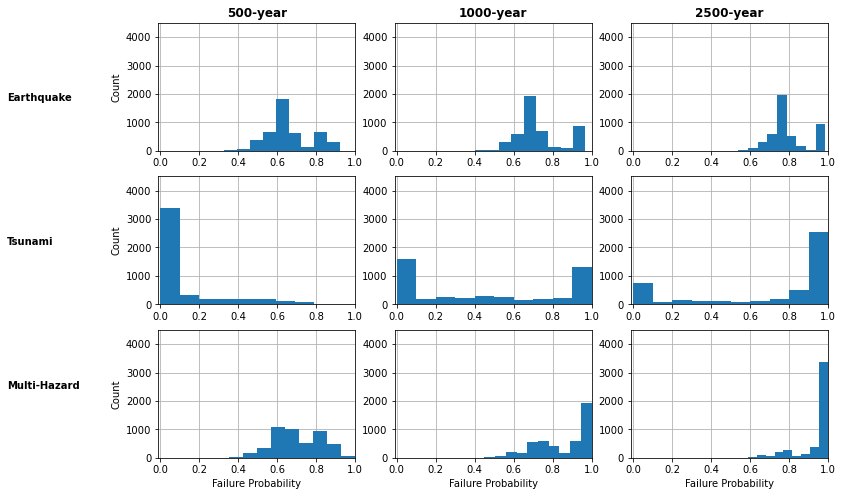

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(12, 8))
rt = [500, 1000, 2500]

for i, rt_val in enumerate(rt):
    ax[0, i].hist(data_eq_store['failure_prob_{}' .format(rt_val)], density=False, zorder=2)
    ax[1, i].hist(data_tsu_store['failure_prob_{}' .format(rt_val)], density=False, zorder=2)
    ax[2, i].hist(data_cumulative_store['failure_prob_{}' .format(rt_val)], density=False, zorder=2, bins=10)
    ax[0,i].set_xlim([-0.01,1])
    ax[1,i].set_xlim([-0.01,1])
    ax[2,i].set_xlim([-0.01,1])
    ax[0,i].set_ylim([0,4500])
    ax[1,i].set_ylim([0,4500])
    ax[2,i].set_ylim([0,4500])

    ax[0,i].grid(zorder=0)
    ax[1,i].grid(zorder=0)
    ax[2,i].grid(zorder=0)
    
fig.text(-0.05, 0.75, 'Earthquake', va='center', weight='bold')
fig.text(-0.05, 0.5, 'Tsunami', va='center', weight='bold')
fig.text(-0.05, 0.25, 'Multi-Hazard', va='center', weight='bold')

ax[0,0].set_title('{}-year' .format(rt[0]), weight='bold')
ax[0,1].set_title('{}-year' .format(rt[1]), weight='bold')
ax[0,2].set_title('{}-year' .format(rt[2]), weight='bold')

ax[0,0].set_ylabel('Count')
ax[1,0].set_ylabel('Count')
ax[2,0].set_ylabel('Count')

ax[2,0].set_xlabel('Failure Probability')
ax[2,1].set_xlabel('Failure Probability')
ax[2,2].set_xlabel('Failure Probability')

#### 4.2. Computing expected economic losses

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


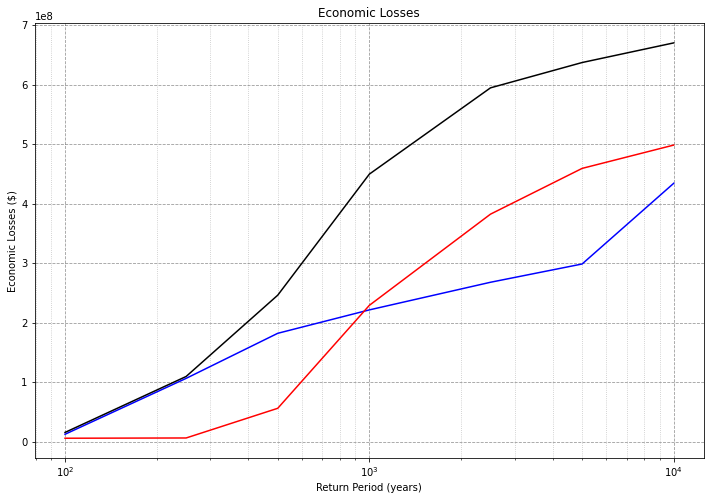

In [10]:
damage_factor_mean = [0.005, 0.155, 0.55, 0.90]  # from MAEVIS documentation
rt = [100, 250, 500, 1000, 2500, 5000, 10000]

# reading in rmv values of each building
bldg_dmg = BuildingDamage(client)                   # initializing pyincore
bldg_dataset_id = "5df40388b9219c06cf8b0c80"
bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
dataset = bldg_dmg.input_datasets['buildings']['value']
rd = dataset.get_inventory_reader()

rmv = []
for row in rd:
    rmv.append(row['properties']['rmv_improv'])

# storing rmv data in each dataframe
data_eq_store['rmv'] = rmv
data_tsu_store['rmv'] = rmv
data_cumulative_store['rmv'] = rmv

loss_eq_tot = []
loss_tsu_tot = []
loss_cumulative_tot = []

for rt_val in rt:
    loss_insg = data_eq_store['rmv']*data_eq_store['insignific_{}' .format(rt_val)]*damage_factor_mean[0]
    loss_modr = data_eq_store['rmv']*data_eq_store['moderate_{}' .format(rt_val)]*damage_factor_mean[1]
    loss_heav = data_eq_store['rmv']*data_eq_store['heavy_{}' .format(rt_val)]*damage_factor_mean[2]
    loss_comp = data_eq_store['rmv']*data_eq_store['complete_{}' .format(rt_val)]*damage_factor_mean[3]
    loss_eq = loss_insg + loss_modr + loss_heav + loss_comp
    
    loss_insg = data_tsu_store['rmv']*data_tsu_store['insignific_{}' .format(rt_val)]*damage_factor_mean[0]
    loss_modr = data_tsu_store['rmv']*data_tsu_store['moderate_{}' .format(rt_val)]*damage_factor_mean[1]
    loss_heav = data_tsu_store['rmv']*data_tsu_store['heavy_{}' .format(rt_val)]*damage_factor_mean[2]
    loss_comp = data_tsu_store['rmv']*data_tsu_store['complete_{}' .format(rt_val)]*damage_factor_mean[3]
    loss_tsu = loss_insg + loss_modr + loss_heav + loss_comp
    
    loss_insg = data_cumulative_store['rmv']*data_cumulative_store['insignific_{}' .format(rt_val)]*damage_factor_mean[0]
    loss_modr = data_cumulative_store['rmv']*data_cumulative_store['moderate_{}' .format(rt_val)]*damage_factor_mean[1]
    loss_heav = data_cumulative_store['rmv']*data_cumulative_store['heavy_{}' .format(rt_val)]*damage_factor_mean[2]
    loss_comp = data_cumulative_store['rmv']*data_cumulative_store['complete_{}' .format(rt_val)]*damage_factor_mean[3]
    loss_cumulative = (loss_insg + loss_modr + loss_heav + loss_comp)
    
    loss_eq_tot.append(loss_eq.sum())
    loss_tsu_tot.append(loss_tsu.sum())
    loss_cumulative_tot.append(loss_cumulative.sum())

fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(rt, loss_eq_tot, 'b', ls='-')
ax.plot(rt, loss_tsu_tot, 'r', ls='-')
ax.plot(rt, loss_cumulative_tot, 'k', ls='-')

ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Economic Losses ($)')
ax.set_title("Economic Losses")

ax.set_xscale('log')
ax.grid(which='minor', alpha=0.25, color = 'k', ls = ':')
ax.grid(which='major', alpha=0.40, color = 'k', ls = '--')

#### 4.3. Computing expected economic risks
Risks are defined as losses times probability of occurrence (or the inverserse of the return period). With economic risks, one can isolate events that result in both large economic losses, as well as have a high probability of occurrence. 

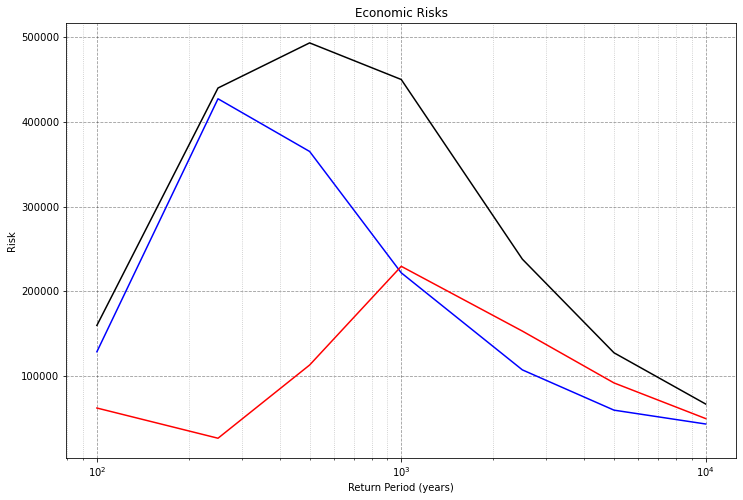

In [11]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

risk_eq = [l/r for l,r in zip(loss_eq_tot, rt)]
risk_tsu = [l/r for l,r in zip(loss_tsu_tot, rt)]
risk_cumulative = [l/r for l,r in zip(loss_cumulative_tot, rt)]

ax.plot(rt, risk_eq, 'b', ls='-')
ax.plot(rt, risk_tsu, 'r', ls='-')
ax.plot(rt, risk_cumulative, 'k', ls='-')

ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Risk')
ax.set_title("Economic Risks")

ax.set_xscale('log')
ax.grid(which='minor', alpha=0.25, color = 'k', ls = ':')
ax.grid(which='major', alpha=0.40, color = 'k', ls = '--')

### 5. Plotting Geospatial Results
<span style="color:red"> __Use ipyleaflet v0.10.5 for best rendering of maps__
    
The below shows the results of the failure probabilities geospatially. The user selects the output file that is viewed, then selects "Generate Map". Each building is then color coded according to the failure probabilities from the MC results. 

In [12]:
# showing mc earthquake building damage result
m = viz.plot_table_dataset(client, mc_bldg_eq_dmg_result_list, 'failure_probability', '5d927ab2b9219c06ae8d313c')
m            # showing maps in notebook

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


Map(center=[45.99418262960843, -123.92451248382656], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [13]:
# showing mc tsunami building damage result
m = viz.plot_table_dataset(client, mc_bldg_tsu_dmg_result_list, 'failure_probability', '5d927ab2b9219c06ae8d313c')
m

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


Map(center=[45.99418262960843, -123.92451248382656], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [14]:
# showing mc cumulative building damage result
m = viz.plot_table_dataset(client, mc_bldg_cumul_dmg_result_list, 'failure_probability', '5d927ab2b9219c06ae8d313c')
m

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


Map(center=[45.99418262960843, -123.92451248382656], controls=(ZoomControl(options=['position', 'zoom_in_text'…